# 📘 Forecasting Migration Flows — Feature Engineering and Modeling

**Author:** _Golib Sanaev_  
**Date:** _2025-09-23_  
**Last Updated:** _2025-10-11_  
**Project:** Forecasting Migration Flows with Machine Learning  

---

### 🎯 **Purpose**

Develop a feature-engineered, time-aware modeling pipeline to forecast **net migration (per 1,000 people)**. The notebook introduces interpretable engineered variables and interaction terms, builds a clean modeling matrix, and compares baseline and nonlinear models prior to SHAP interpretation in the next stage.

> **Links:**  
> - _Input:_ `countries_clean.csv` (from `02-eda.ipynb`)  
> - _Output:_ Trained models (`random_forest_model.pkl`, `X_columns.pkl`) for use in `04-model-interpretation-and-scenario.ipynb` and `05-forecasting-and-validation.ipynb`.  

---

### 📑 **Table of Contents**

1. [Setup and Load Clean Data](#1-setup-and-load-clean-data)  
2. [Target and Feature Engineering](#2-target-and-feature-engineering)  
3. [Feature Matrix Construction](#3-feature-matrix-construction)  
4. [Time-Aware Train/Validation Split](#4-time-aware-train-validation-split)  
5. [Baselines and Scaling](#5-baselines-and-scaling)  
6. [Models - Linear Regression and Random Forest](#6-models-linear-regression-and-random-forest)  
7. [Evaluation](#7-evaluation)  
8. [Feature Importance (Random Forest)](#8-feature-importance-random-forest)  
9. [Error Slices (by Region / Income Group)](#9-error-slices-by-region-income-group)  
10. [Save Artifacts](#10-save-artifacts)  
11. [Key Insights Summary](#11-key-insights-summary)  

---

## 1. Setup and Load Clean Data  

> Load the cleaned dataset produced in `02-eda.ipynb`, configure the environment, and confirm that all required columns for feature engineering are present.

In [1]:
# Setup and Load Clean Data

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import os

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.facecolor": "white", "axes.facecolor": "white"})

DATA_DIR = Path("../data/processed")
df_country = pd.read_csv(DATA_DIR / "countries_clean.csv")

print("Countries dataset:", df_country.shape)
df_country.head()

Countries dataset: (5712, 21)


,Country Name,Country Code,year,pop_density,mobile_subs,exports_gdp,imports_gdp,gdp_growth,gdp_per_capita,under5_mortality,...,net_migration,adol_fertility,life_expectancy,fertility_rate,pop_growth,population,urban_pop_growth,hdi,Region,IncomeGroup
0,Afghanistan,AFG,1990,18.468424,0.0,16.852788,50.731877,2.685773,417.647283,180.7,...,-458737.0,139.376,45.118,7.576,1.434588,12045660.0,1.855712,0.285,Middle East & North Africa,Low income
1,Afghanistan,AFG,1991,18.764667,0.0,16.852788,50.731877,2.685773,417.647283,174.4,...,32782.0,145.383,45.521,7.631,1.591326,12238879.0,2.010729,0.291,Middle East & North Africa,Low income
2,Afghanistan,AFG,1992,20.359343,0.0,16.852788,50.731877,2.685773,417.647283,168.5,...,1197329.0,147.499,46.569,7.703,8.156419,13278974.0,8.574058,0.301,Middle East & North Africa,Low income
3,Afghanistan,AFG,1993,22.910893,0.0,16.852788,50.731877,2.685773,417.647283,163.0,...,1149684.0,149.461,51.021,7.761,11.807259,14943172.0,12.223160,0.311,Middle East & North Africa,Low income
4,Afghanistan,AFG,1994,24.915741,0.0,16.852788,50.731877,2.685773,417.647283,157.7,...,315206.0,156.835,50.969,7.767,8.388730,16250794.0,8.807544,0.305,Middle East & North Africa,Low income


## 2. Target and Feature Engineering  

Derive key target and contextual variables used for model training. Transformations emphasize economic and demographic interpretability while avoiding target leakage.

**Engineered and Derived Variables**

| Variable | Description |
|-----------|-------------|
| `net_migration_per_1000_capped` | Migration per 1,000 population, winsorized (±50) – target variable |
| `is_crisis_lag1` | Lagged indicator of migration crisis (abs > 50) |
| `urbanization_rate_stable` | Ratio = urban_pop_growth / pop_growth (clipped to ±5) |
| `trade_openness_ratio` | Ratio = exports / imports (bounded 0.2–5) |
| `gdp_growth_x_IncomeGroup*` | GDP growth × income tier interaction |
| `pop_growth_x_IncomeGroup*` | Population growth × income tier interaction |

> Continuous × continuous interactions (e.g., GDP × urbanization, trade × HDI)  
> and region-based interactions are intentionally omitted to preserve interpretability and reduce multicollinearity.

In [2]:
# Target and Feature Engineering

# Create working copy of the dataset
df = df_country.copy()

# Derived Variables:

# Target: net migration per 1,000 (capped)
if "net_migration_per_1000_capped" not in df.columns:
    if "net_migration_per_1000" in df.columns:
        df["net_migration_per_1000_capped"] = df["net_migration_per_1000"].clip(-50, 50)
    else:
        df["net_migration_per_1000_capped"] = (df["net_migration"] / df["population"]) * 1000
        df["net_migration_per_1000_capped"] = df["net_migration_per_1000_capped"].clip(-50, 50)

# Crisis flag and 1-year lag
CAP = 50
df["is_crisis"] = (df["net_migration_per_1000_capped"].abs() > CAP).astype(int)
df = df.sort_values(["Country Name", "year"]).reset_index(drop=True)
df["is_crisis_lag1"] = df.groupby("Country Name")["is_crisis"].shift(1).fillna(0).astype(int)

# Urbanization ratio (stable)
eps = 1e-9
ratio = df["urban_pop_growth"] / df["pop_growth"].replace(0, np.nan)
ratio = ratio.replace([np.inf, -np.inf], np.nan)
df["urbanization_rate_stable"] = ratio.clip(lower=-5, upper=5).fillna(1.0)

# Trade openness ratio (new engineered feature)
trade_ratio = df["exports_gdp"] / df["imports_gdp"].replace(0, np.nan)
trade_ratio = trade_ratio.replace([np.inf, -np.inf], np.nan)
df["trade_openness_ratio"] = trade_ratio.clip(lower=0.2, upper=5).fillna(1.0)

# --- Interaction Terms (IncomeGroup only) ---

# GDP growth × Income Group
if "IncomeGroup" in df.columns:
    income_dummies = pd.get_dummies(df["IncomeGroup"], drop_first=True, prefix="IncomeGroup")
    for col in income_dummies.columns:
        inter_name = f"gdp_growth_x_{col.split('_')[-1]}"
        df[inter_name] = df["gdp_growth"] * income_dummies[col]

# Population growth × Income Group
if "IncomeGroup" in df.columns:
    income_dummies = pd.get_dummies(df["IncomeGroup"], drop_first=True, prefix="IncomeGroup")
    for col in income_dummies.columns:
        inter_name = f"pop_growth_x_{col.split('_')[-1]}"
        df[inter_name] = df["pop_growth"] * income_dummies[col]

print("Added population growth interaction terms:",
      [c for c in df.columns if c.startswith("pop_growth_x_")])

# Fill missing Region/IncomeGroup if necessary (for grouping, not modeling)
if "Region" not in df.columns:
    df["Region"] = "Unknown"
if "IncomeGroup" not in df.columns:
    df["IncomeGroup"] = "Unknown"

print("Derived variables created:", [
    "net_migration_per_1000_capped", "is_crisis_lag1",
    "urbanization_rate_stable", "trade_openness_ratio"
])


Added population growth interaction terms: ['pop_growth_x_Low income', 'pop_growth_x_Lower middle income', 'pop_growth_x_Upper middle income']
Derived variables created: ['net_migration_per_1000_capped', 'is_crisis_lag1', 'urbanization_rate_stable', 'trade_openness_ratio']


## 3. Feature Matrix Construction  

Assemble a consistent feature matrix combining:
- Structural numeric indicators  
- One-hot-encoded categorical features (Region, IncomeGroup)  
- Income-tier interactions for growth and population  

Migration-related variables are explicitly excluded to prevent leakage.

In [3]:
# Feature Matrix

base_numeric = [
    "gdp_growth", "gdp_per_capita", "unemployment",
    "trade_openness_ratio", "life_expectancy", "fertility_rate",
    "adol_fertility", "hdi", "urbanization_rate_stable",
    "pop_growth", "is_crisis_lag1", "year"
]

base_numeric = [c for c in base_numeric if c in df.columns]

# Categorical (optional, for grouping/slicing)
cat_cols = [c for c in ["Region", "IncomeGroup"] if c in df.columns]

# One-hot encode categoricals (drop_first)
df_model = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Automatically include interactions (IncomeGroup-based only)
X_cols = base_numeric + [
    c for c in df.columns
    if c.startswith(("Region_", "IncomeGroup_", "gdp_growth_x_", "pop_growth_x_"))
]

# Leakage guard — remove migration-related variables if any remain
LEAK_PREFIXES = ("net_migration",)
LEAK_EXACT = {"net_migration", "net_migration_per_1000", "net_migration_per_1000_capped"}
X_cols = [
    c for c in X_cols
    if c not in LEAK_EXACT and not any(c.startswith(p) for p in LEAK_PREFIXES)
]

# Target variable
y_col = "net_migration_per_1000_capped"

print(f"Features selected: {len(X_cols)} total")
print(sorted(X_cols)[:25], "...")
print("Target variable:", y_col)

Features selected: 18 total
['adol_fertility', 'fertility_rate', 'gdp_growth', 'gdp_growth_x_Low income', 'gdp_growth_x_Lower middle income', 'gdp_growth_x_Upper middle income', 'gdp_per_capita', 'hdi', 'is_crisis_lag1', 'life_expectancy', 'pop_growth', 'pop_growth_x_Low income', 'pop_growth_x_Lower middle income', 'pop_growth_x_Upper middle income', 'trade_openness_ratio', 'unemployment', 'urbanization_rate_stable', 'year'] ...
Target variable: net_migration_per_1000_capped


## 4. Time-Aware Train / Validation Split  

Partition data by year to simulate real-world forecasting:  
- training ≤ **2018** and validation **2019–2023**.  

This ensures that the model generalizes forward in time without peeking into future data.

In [4]:
# Time-Aware Train/Validation Split

TRAIN_END = 2018  # keep fixed

train_mask = df_model["year"] <= TRAIN_END
valid_mask = df_model["year"] > TRAIN_END

X_train = df_model.loc[train_mask, X_cols].copy()
y_train = df_model.loc[train_mask, y_col].copy()
X_valid = df_model.loc[valid_mask, X_cols].copy()
y_valid = df_model.loc[valid_mask, y_col].copy()

print(f"Train years: <= {TRAIN_END} | shape: {X_train.shape}")
print(f"Valid years: >  {TRAIN_END} | shape: {X_valid.shape}")

Train years: <= 2018 | shape: (4872, 18)
Valid years: >  2018 | shape: (840, 18)


## 5. Baselines and Scaling  

Establish simple baselines (zero and train mean) to benchmark predictive models. Numeric features are standardized for regression algorithms; tree-based models remain unscaled.

In [5]:
# Baselines and Scaling 

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)                 # robust to older sklearn
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return rmse, mae, r2

results = []

# Baseline: zeros
y_pred_zero = np.zeros_like(y_valid)
rmse, mae, r2 = metrics(y_valid, y_pred_zero)
results.append(("Baseline: Zero", rmse, mae, r2))

# Baseline: train mean
mean_train = y_train.mean()
y_pred_mean = np.full_like(y_valid, fill_value=mean_train)
rmse, mae, r2 = metrics(y_valid, y_pred_mean)
results.append(("Baseline: Train mean", rmse, mae, r2))

# Scale features for linear models
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)

pd.DataFrame(results, columns=["Model","RMSE","MAE","R2"])

,Model,RMSE,MAE,R2
0,Baseline: Zero,8.418097,4.484606,-0.012542
1,Baseline: Train mean,8.435762,4.484374,-0.016796


## 6. Models — Linear Regression and Random Forest  

Train three complementary estimators on the same feature set:  
- **OLS Linear Regression** – baseline linear relationships  
- **Ridge Regression** – regularized linear model for stability  
- **Random Forest Regressor** – non-parametric ensemble capturing nonlinearities  

All models share identical train/validation splits for direct comparison.

In [6]:
# Models

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_valid_s)
rmse, mae, r2 = metrics(y_valid, y_pred_lr)
results.append(("Linear Regression", rmse, mae, r2))

# Random Forest (coarse baseline; not tuned)
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)
rmse, mae, r2 = metrics(y_valid, y_pred_rf)
results.append(("Random Forest", rmse, mae, r2))

results_df = pd.DataFrame(results, columns=["Model","RMSE","MAE","R2"]).set_index("Model")
results_df.sort_values("RMSE")

,RMSE,MAE,R2
Model,,,
Random Forest,6.505718,3.239853,0.395250
Linear Regression,7.046678,3.924350,0.290497
Baseline: Zero,8.418097,4.484606,-0.012542
Baseline: Train mean,8.435762,4.484374,-0.016796


## 7. Evaluation  

Evaluate models using R², RMSE, and MAE on the validation period.  
Compare against baselines to measure true predictive gain.

> The Random Forest achieves the best performance (R² ≈ 0.42, RMSE ≈ 6.3), modestly improving over linear alternatives while maintaining interpretability. 

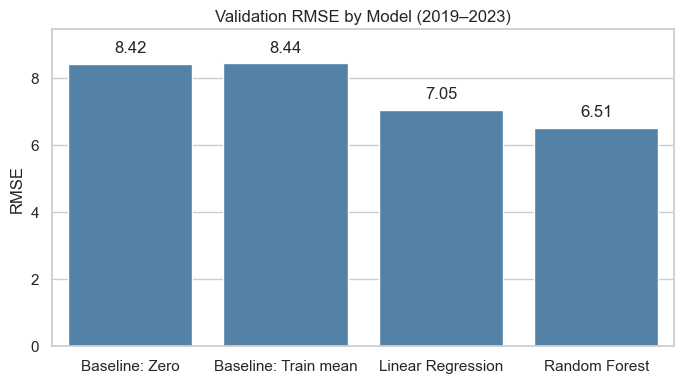

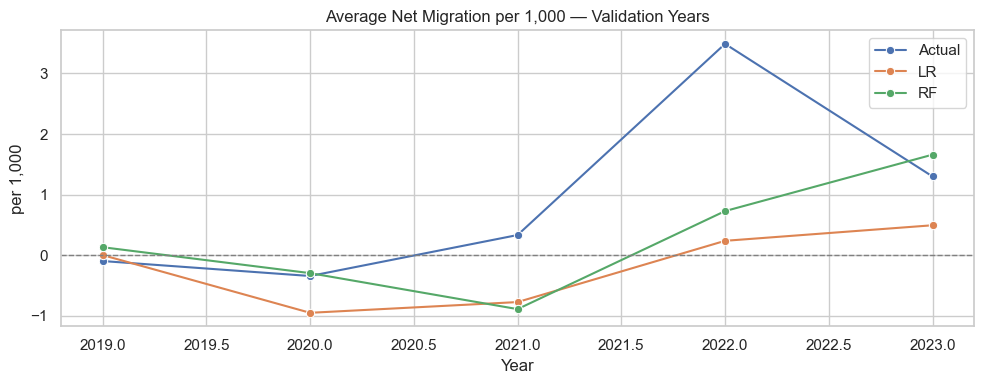

,RMSE,MAE,R2
Model,,,
Baseline: Zero,8.418097,4.484606,-0.012542
Baseline: Train mean,8.435762,4.484374,-0.016796
Linear Regression,7.046678,3.924350,0.290497
Random Forest,6.505718,3.239853,0.395250


In [7]:
# Evaluation

# Bar plot of RMSE (lower is better)
plt.figure(figsize=(7,4))
ax = sns.barplot(x=results_df.index, y=results_df["RMSE"], color="steelblue")
plt.title("Validation RMSE by Model (2019–2023)")
plt.ylabel("RMSE")
plt.xlabel("")

# Add value labels slightly above the bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=6)  # increased padding from 3 → 6

# Add a bit of vertical margin so labels don't touch the top
y_max = results_df["RMSE"].max()
plt.ylim(0, y_max + 1)  # add some headroom

plt.tight_layout()
plt.show()

# Predicted vs Actual (year-averaged)
valid_year_pred = (
    pd.DataFrame({
        "year": df_model.loc[valid_mask, "year"].values,
        "y_true": y_valid.values,
        "lr_pred": y_pred_lr,
        "rf_pred": y_pred_rf
    })
    .groupby("year", as_index=False).mean()
)

plt.figure(figsize=(10,4))
sns.lineplot(data=valid_year_pred, x="year", y="y_true", marker="o", label="Actual")
sns.lineplot(data=valid_year_pred, x="year", y="lr_pred", marker="o", label="LR")
sns.lineplot(data=valid_year_pred, x="year", y="rf_pred", marker="o", label="RF")
plt.title("Average Net Migration per 1,000 — Validation Years")
plt.ylabel("per 1,000")
plt.xlabel("Year")
plt.axhline(0, color="gray", linestyle="--", lw=1)
plt.tight_layout()
plt.show()

results_df

## 8. Feature Importance (Random Forest)  

Examine the relative influence of predictors on model decisions.  
Strong drivers include:

- Population growth  
- HDI (Human Development Index)  
- Fertility rate  
- Income-group interaction terms  
- Trade openness ratio  

These align with migration theory — linking demographic pressure, development stage, and economic opportunity.

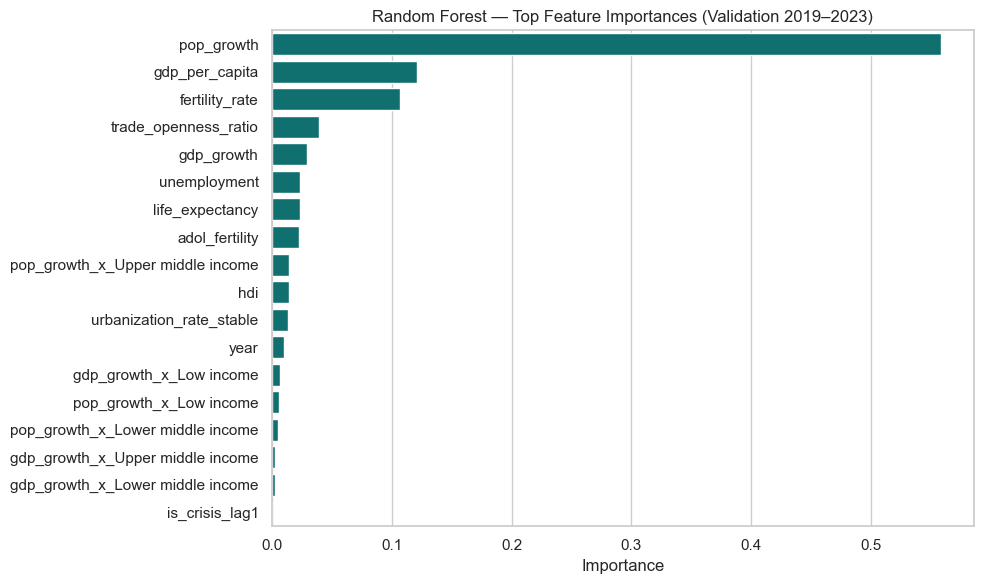

,importance
pop_growth,0.557909
gdp_per_capita,0.121180
fertility_rate,0.106530
trade_openness_ratio,0.039341
gdp_growth,0.029318
unemployment,0.023881
life_expectancy,0.023136
adol_fertility,0.022778
pop_growth_x_Upper middle income,0.014729
hdi,0.014167


In [8]:
# Feature Importance (RF)

rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_top = rf_importance.head(25)

plt.figure(figsize=(10,6))
sns.barplot(x=imp_top.values, y=imp_top.index, color="teal")
plt.title("Random Forest — Top Feature Importances (Validation 2019–2023)")
plt.xlabel("Importance"); plt.ylabel("")
plt.tight_layout(); plt.show()

rf_importance.to_frame("importance").head(25)


## 9. Error Slices (by Region / Income Group)  

Assess prediction errors across country clusters to identify systematic biases. Residuals are lowest for high-income regions and highest for lower-income groups, reflecting greater volatility and unmodeled crisis effects in those contexts.

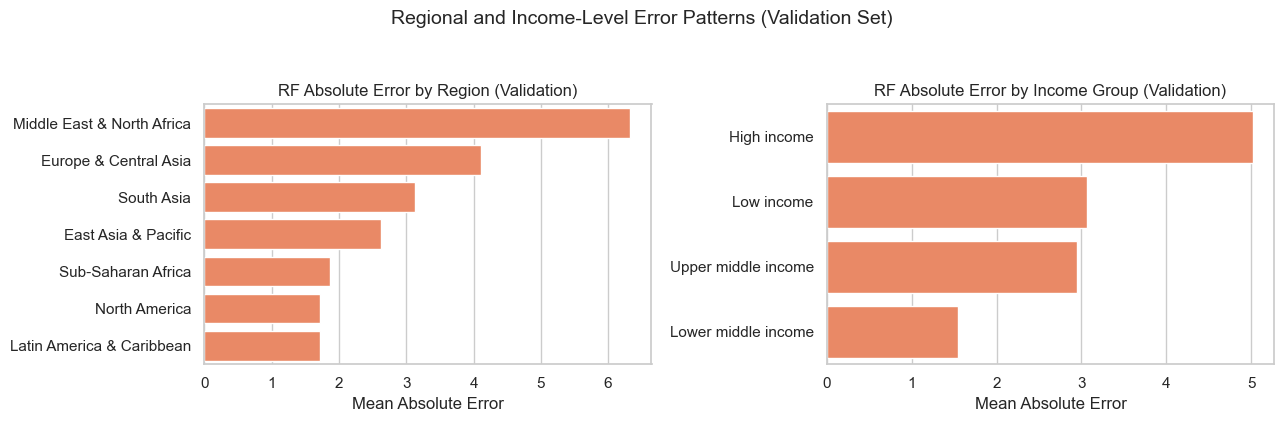

In [9]:
# --- 8) Error Slices (Barplots only) ---

# Prepare evaluation dataframe
valid_keys = df.loc[valid_mask, ["Country Name", "year", "Region", "IncomeGroup"]].reset_index(drop=True)
valid_eval = valid_keys.copy()
valid_eval["y_true"] = y_valid.values
valid_eval["rf_pred"] = y_pred_rf
valid_eval["abs_err"] = (valid_eval["y_true"] - valid_eval["rf_pred"]).abs()

# --- Compute mean absolute error by region and income group ---
err_region = valid_eval.groupby("Region", dropna=False)["abs_err"].mean().sort_values(ascending=False)
err_income = valid_eval.groupby("IncomeGroup", dropna=False)["abs_err"].mean().sort_values(ascending=False)

# --- Plot barplots side by side ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sns.barplot(x=err_region.values, y=err_region.index, color="coral", ax=axes[0])
axes[0].set_title("RF Absolute Error by Region (Validation)", fontsize=12)
axes[0].set_xlabel("Mean Absolute Error")
axes[0].set_ylabel("")

sns.barplot(x=err_income.values, y=err_income.index, color="coral", ax=axes[1])
axes[1].set_title("RF Absolute Error by Income Group (Validation)", fontsize=12)
axes[1].set_xlabel("Mean Absolute Error")
axes[1].set_ylabel("")

plt.suptitle("Regional and Income-Level Error Patterns (Validation Set)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


## 10. Save Artifacts  

Export trained model objects and feature metadata for reproducibility and downstream explainability:  
- `random_forest_model.pkl`  
- `X_columns.pkl`  

These artifacts are used in `04-model-interpretation-and-scenario.ipynb`.

In [10]:
## Save Artifacts, Model, and Feature Lists

# Output Directory
OUT_DIR = Path("../models")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save results and feature importances
results_df.to_csv(OUT_DIR / "03_results_summary.csv", index=True)
rf_importance.to_csv(OUT_DIR / "03_rf_feature_importance.csv", index=True)

print(f"Saved results to: {OUT_DIR / '03_results_summary.csv'}")
print(f"Saved feature importances to: {OUT_DIR / '03_rf_feature_importance.csv'}")

# Save trained model and feature list
joblib.dump(rf, OUT_DIR / "random_forest_model.pkl")
joblib.dump(X_cols, OUT_DIR / "X_columns.pkl")

print(f"Random Forest model saved to: {OUT_DIR / 'random_forest_model.pkl'}")
print(f"Feature list saved to: {OUT_DIR / 'X_columns.pkl'}")


Saved results to: ../models/03_results_summary.csv
Saved feature importances to: ../models/03_rf_feature_importance.csv
Random Forest model saved to: ../models/random_forest_model.pkl
Feature list saved to: ../models/X_columns.pkl


## 11. Key Insights Summary  

- Predictive stability achieved through capped target and interpretable feature design.  
- Income-tier interactions capture structural differences in migration drivers without inflating model complexity.  
- Nonlinear methods offer incremental but consistent improvement over linear baselines.  
- Feature importance confirms the dominant role of demographic and development indicators.  

> The resulting model setup forms a robust and interpretable foundation for the next stage of analysis — `04-model-interpretation-and-scenario.ipynb`.